# GBM Rolling VaR Backtesting (Baseline Model)

**Goal**  
Use a Geometric Brownian Motion (GBM) model as a baseline to forecast next-day risk and test whether those forecasts match reality.

This notebook performs a **rolling 1-day VaR/ES backtest**:
- Each day, fit GBM parameters using a fixed historical window (e.g., last 252 trading days)
- Simulate next-day return scenarios with Monte Carlo
- Compute VaR and Expected Shortfall (ES) at 95% and 99%
- Compare forecasts to the realized next-day return and record breaches (“exceptions”)

**Inputs**  
This notebook assumes the processed dataset created in `01_data_features.ipynb` already exists:
- `data/processed/prices_returns.parquet`

**Outputs saved to Drive**
- `outputs/tables/gbm_backtest_results.csv` (daily forecasts + realized outcomes + breach flags)
- `outputs/tables/gbm_scorecard.csv` (breach rates vs expected, per ticker and confidence level)
- `outputs/figures/*` (diagnostic plots: realized loss vs VaR, cumulative breaches)

**Why this notebook exists**  
GBM is intentionally treated as a **baseline**. The next notebooks will add:
- Jump Diffusion (Poisson jumps) to address fat tails
- Markov regime-switching volatility to address volatility clustering  
and will be evaluated using the same backtesting framework.


In [7]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from pathlib import Path

PROJECT_NAME = "equity_var_backtesting"
BASE = Path("/content/drive/MyDrive") / PROJECT_NAME

DIRS = {
    "data_processed": BASE / "data" / "processed",
    "tables": BASE / "outputs" / "tables",
    "figures": BASE / "outputs" / "figures",
    "src": BASE / "src",
}

for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = DIRS["data_processed"] / "prices_returns.parquet"
DATA_PATH


PosixPath('/content/drive/MyDrive/equity_var_backtesting/data/processed/prices_returns.parquet')

In [9]:
!pip -q install pandas numpy pyarrow matplotlib yfinance


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (12, 5)

TRADING_DAYS = 252
SEED = 42

WINDOW = 252          # rolling estimation window (1 year)
N_PATHS = 10000       # dev: 5k–10k; final: 20k+
VAR_LEVELS = [0.95, 0.99]


In [11]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,ticker,price,log_return,realized_vol_20d
0,2015-01-02,AAPL,24.237551,NaN,NaN
1,2015-01-05,AAPL,23.554741,-0.028576,NaN
2,2015-01-06,AAPL,23.556965,0.000094,NaN
3,2015-01-07,AAPL,23.887274,0.013924,NaN
4,2015-01-08,AAPL,24.805077,0.037702,NaN


In [12]:
# wide matrix of daily log returns: index=date, columns=ticker
logret = df.pivot(index="date", columns="ticker", values="log_return").sort_index()

# keep only dates where at least 1 ticker has returns
logret = logret.dropna(how="all")
logret.tail()


ticker,AAPL,JPM,MSFT,SPY,TSLA,XOM
date,,,,,,
2025-12-15,-0.015098,0.004698,-0.007783,-0.001512,0.035004,-0.008961
2025-12-16,0.001822,-0.014066,0.003301,-0.002736,0.030193,-0.026503
2025-12-17,-0.010138,-0.001808,-0.000567,-0.011065,-0.047275,0.023526
2025-12-18,0.001287,-0.006306,0.016374,0.007523,0.033897,-0.007438
2025-12-19,0.005423,0.013361,0.004000,0.009023,-0.004499,0.001286


In [13]:
#coverage per ticker
coverage = logret.notna().sum().sort_values(ascending=False)
display(pd.DataFrame({"n_returns": coverage}))
print("Total dates:", len(logret))


,n_returns
ticker,
AAPL,2758
JPM,2758
MSFT,2758
SPY,2758
TSLA,2758
XOM,2758


Total dates: 2758


In [14]:
#GBM calibration (annualized)
def calibrate_gbm_annual(log_returns: np.ndarray, trading_days=252):
    """
    Calibrate GBM parameters from daily log returns.
    Returns annualized (mu, sigma).
    """
    r = np.asarray(log_returns)
    r = r[~np.isnan(r)]
    mu_daily = r.mean()
    sig_daily = r.std(ddof=1)

    mu_annual = mu_daily * trading_days
    sigma_annual = sig_daily * np.sqrt(trading_days)
    return float(mu_annual), float(sigma_annual)


In [15]:
# 1-day GBM simple returns (Monte Carlo Simulation)
def simulate_gbm_1d_returns(mu, sigma, n_paths=10000, seed=42, trading_days=252):
    """
    Simulate 1-day simple returns under GBM.
    """
    rng = np.random.default_rng(seed)
    dt = 1 / trading_days
    Z = rng.standard_normal(n_paths)

    log_r = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    return np.exp(log_r) - 1.0


In [16]:
#VaR / ES calculator (loss convention)
def var_es_from_returns(returns: np.ndarray, alpha=0.95):
    """
    returns: simple returns
    Uses loss = -return
    """
    R = np.asarray(returns)
    L = -R
    VaR = np.quantile(L, alpha)
    ES = L[L >= VaR].mean()
    return float(VaR), float(ES)


In [17]:
#Rolling GBM VaR backtest (single ticker)

def backtest_gbm_single_ticker(logret_series: pd.Series,
                               window=252,
                               var_levels=(0.95, 0.99),
                               n_paths=10000,
                               seed=42,
                               trading_days=252):
    """
    Rolling 1-day VaR backtest for one ticker:
    - fit GBM on last `window` days
    - simulate next-day returns
    - compute VaR/ES
    - compare to realized next-day return
    """
    r = logret_series.dropna().copy()
    dates = r.index

    rng = np.random.default_rng(seed)
    rows = []

    # We need i+1 for realized next day, so loop ends at len(r)-2
    for i in range(window, len(r) - 1):
        train = r.iloc[i-window:i].values
        realized_log = float(r.iloc[i+1])

        mu, sigma = calibrate_gbm_annual(train, trading_days=trading_days)

        day_seed = int(rng.integers(1, 1_000_000))
        sim_R = simulate_gbm_1d_returns(mu, sigma, n_paths=n_paths, seed=day_seed, trading_days=trading_days)

        realized_simple = np.exp(realized_log) - 1.0
        realized_loss = -realized_simple

        out = {
            "date": dates[i+1],
            "mu_annual": mu,
            "sigma_annual": sigma,
            "realized_logret": realized_log,
            "realized_simple_return": realized_simple,
            "realized_loss": realized_loss,
        }

        for a in var_levels:
            lvl = int(a * 100)
            VaR, ES = var_es_from_returns(sim_R, alpha=a)
            out[f"VaR_{lvl}"] = VaR
            out[f"ES_{lvl}"] = ES
            out[f"breach_{lvl}"] = bool(realized_loss > VaR)

        rows.append(out)

    return pd.DataFrame(rows)


In [18]:
#Run backtest for all tickers
TICKERS = sorted(logret.columns.tolist())

bt_list = []
for tkr in TICKERS:
    series = logret[tkr]
    bt = backtest_gbm_single_ticker(
        series,
        window=WINDOW,
        var_levels=VAR_LEVELS,
        n_paths=N_PATHS,
        seed=SEED,
        trading_days=TRADING_DAYS
    )
    bt["ticker"] = tkr
    bt["model"] = "GBM"
    bt_list.append(bt)

bt_all = pd.concat(bt_list, ignore_index=True).sort_values(["ticker", "date"])
bt_all.head()


,date,mu_annual,sigma_annual,realized_logret,realized_simple_return,realized_loss,VaR_95,ES_95,breach_95,VaR_99,ES_99,breach_99,ticker,model
0,2016-01-06,-0.020188,0.267325,-0.019763,-0.019569,0.019569,0.028005,0.034702,False,0.038504,0.044041,False,AAPL,GBM
1,2016-01-07,-0.016991,0.267002,-0.043121,-0.042205,0.042205,0.027419,0.033994,True,0.038179,0.044202,True,AAPL,GBM
2,2016-01-08,-0.036848,0.267727,0.005274,0.005288,-0.005288,0.027533,0.034117,False,0.038389,0.044183,False,AAPL,GBM
3,2016-01-11,-0.093894,0.270777,0.016062,0.016192,-0.016192,0.028242,0.035179,False,0.039656,0.044655,False,AAPL,GBM
4,2016-01-12,-0.126322,0.268128,0.014409,0.014513,-0.014513,0.028172,0.034677,False,0.038702,0.043965,False,AAPL,GBM


In [19]:
out_bt = DIRS["tables"] / "gbm_backtest_results.csv"
bt_all.to_csv(out_bt, index=False)
print("Saved:", out_bt)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/gbm_backtest_results.csv


In [20]:
#breach rates vs expected
score_rows = []
for tkr in TICKERS:
    sub = bt_all[bt_all["ticker"] == tkr]
    n = len(sub)
    for a in VAR_LEVELS:
        lvl = int(a * 100)
        breach_col = f"breach_{lvl}"
        score_rows.append({
            "ticker": tkr,
            "model": "GBM",
            "var_level": a,
            "n_obs": n,
            "breaches": int(sub[breach_col].sum()),
            "breach_rate": float(sub[breach_col].mean()),
            "expected_rate": 1 - a
        })

score_df = pd.DataFrame(score_rows).sort_values(["ticker", "var_level"])
display(score_df)


,ticker,model,var_level,n_obs,breaches,breach_rate,expected_rate
0,AAPL,GBM,0.95,2505,139,0.055489,0.05
1,AAPL,GBM,0.99,2505,56,0.022355,0.01
2,JPM,GBM,0.95,2505,113,0.045110,0.05
3,JPM,GBM,0.99,2505,60,0.023952,0.01
4,MSFT,GBM,0.95,2505,139,0.055489,0.05
5,MSFT,GBM,0.99,2505,57,0.022754,0.01
6,SPY,GBM,0.95,2505,136,0.054291,0.05
7,SPY,GBM,0.99,2505,73,0.029142,0.01
8,TSLA,GBM,0.95,2505,118,0.047106,0.05
9,TSLA,GBM,0.99,2505,48,0.019162,0.01


In [21]:
out_score = DIRS["tables"] / "gbm_scorecard.csv"
score_df.to_csv(out_score, index=False)
print("Saved:", out_score)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/gbm_scorecard.csv


In [22]:
#Plot helper: realized loss vs VaR line (with breach dots)
def plot_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int = 99):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"GBM VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs GBM VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


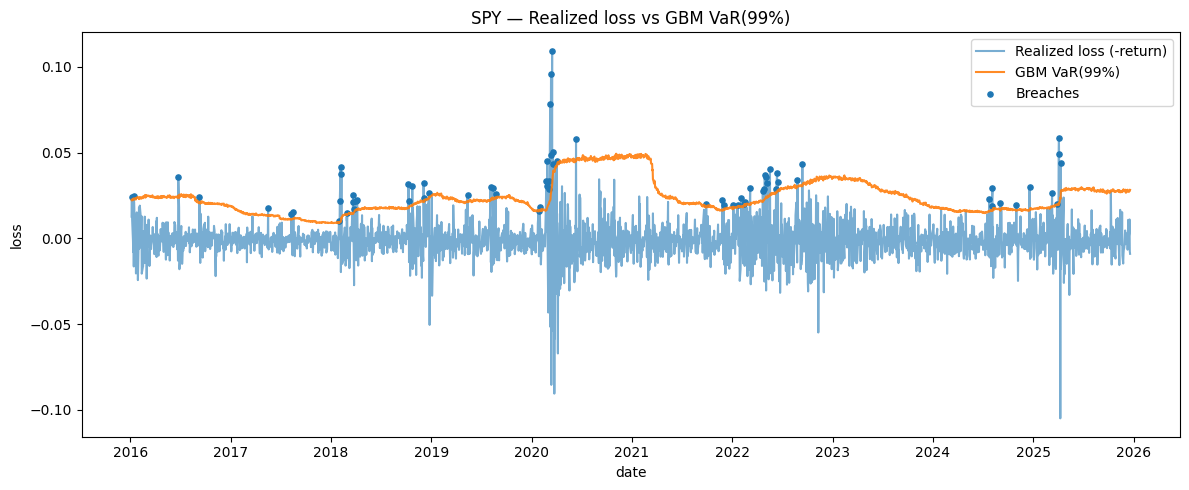

In [23]:
#Plot: SPY (VaR 99%)
plot_realized_vs_var(bt_all, "SPY", 99)


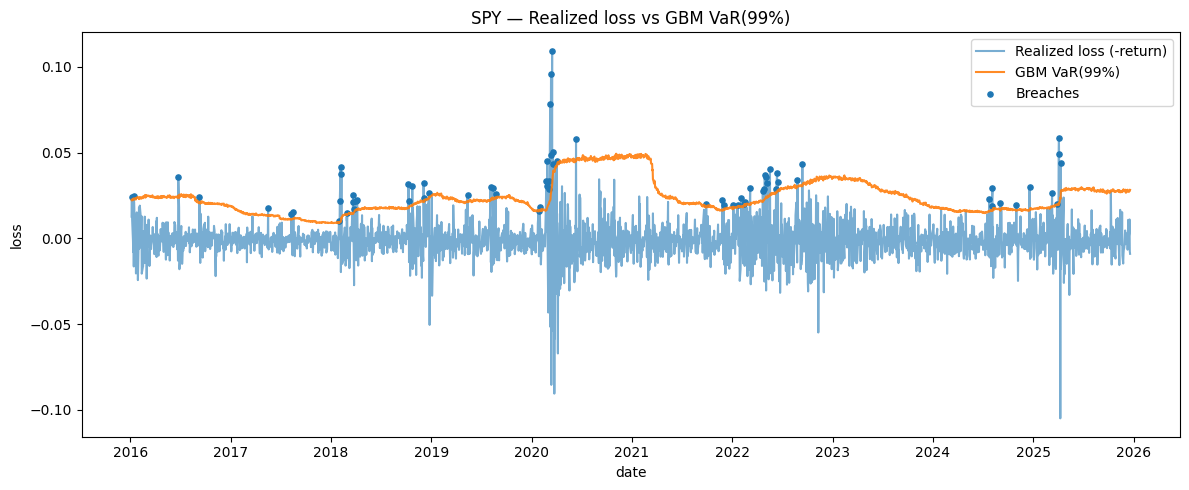

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_GBM_VaR99_realized_vs_var.png


In [24]:
def save_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int, outpath: Path):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"GBM VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs GBM VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

fig_path = DIRS["figures"] / "SPY_GBM_VaR99_realized_vs_var.png"
save_realized_vs_var(bt_all, "SPY", 99, fig_path)


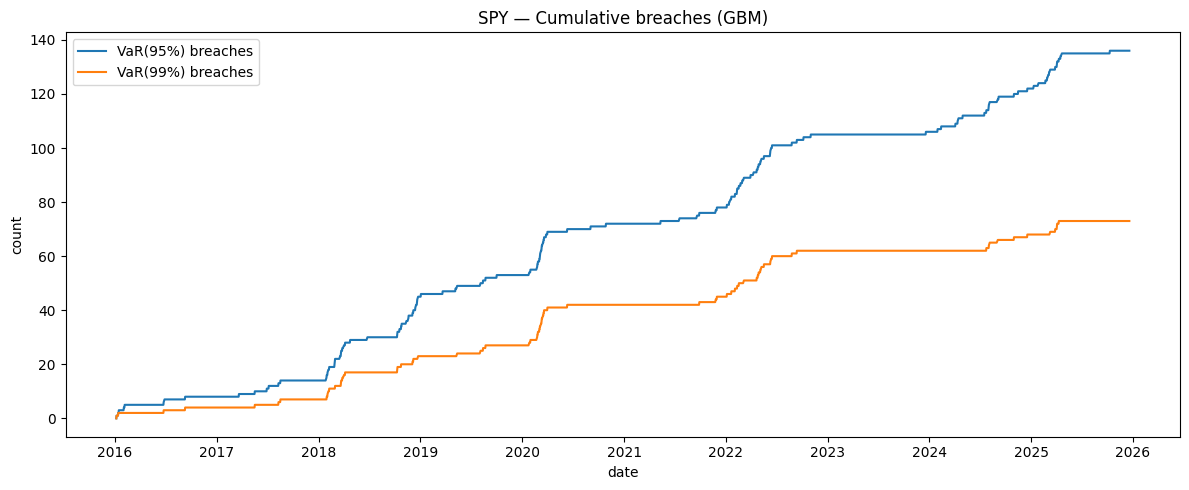

In [25]:
#Cumulative breaches plot
def plot_cumulative_breaches(bt_df: pd.DataFrame, ticker: str):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in VAR_LEVELS:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches (GBM)")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cumulative_breaches(bt_all, "SPY")


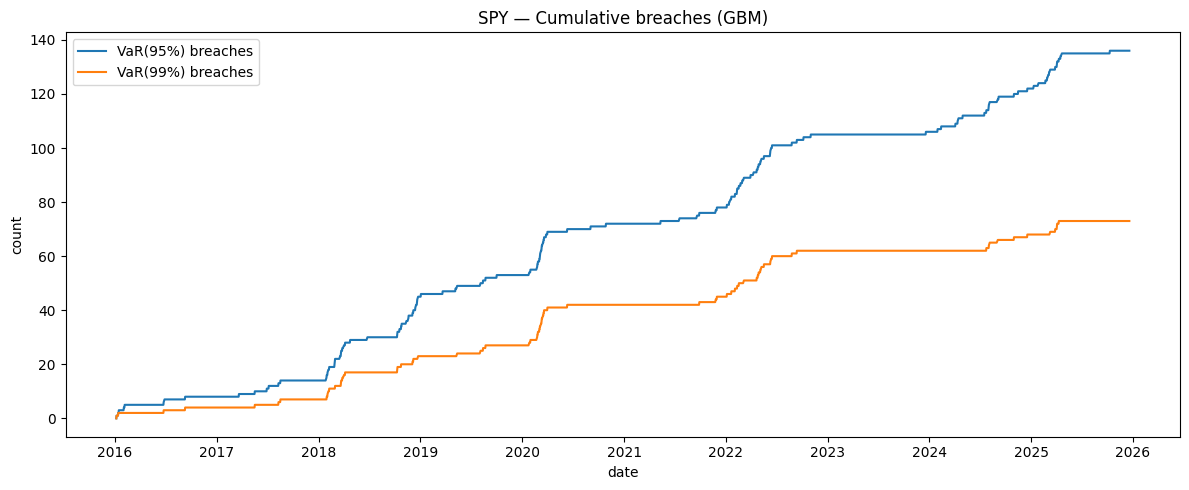

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_GBM_cumulative_breaches.png


In [26]:
def save_cumulative_breaches(bt_df: pd.DataFrame, ticker: str, outpath: Path):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in VAR_LEVELS:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches (GBM)")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

cum_path = DIRS["figures"] / "SPY_GBM_cumulative_breaches.png"
save_cumulative_breaches(bt_all, "SPY", cum_path)
